In [1]:
# 图像分析与理解
# 模糊方法实验 - 边界提取
# 东南大学，卓旭，212138

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from helper import *
from cuFuzzy import fuzzyEdgeExtract3x3

(363, 381)


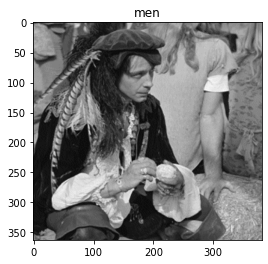

In [3]:
# 1 - 读取men.txt文件
menImg = readImageUint8('men.txt')
print(menImg.shape)
display(menImg, 'men')

In [4]:
# 2 - 隶属度函数 \mu_zero(d)
SIGMA = 10 # 7
def muZeroD(d, sigma=SIGMA): # 调整该sigma以完成步骤6
    return 0 if abs(d) > 2 * sigma else np.exp(-d ** 2 / (2 * sigma ** 2))

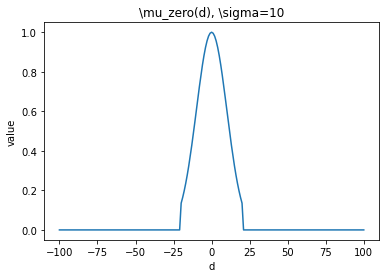

In [5]:
xs = np.arange(-100, 100 + 1)
ys = [muZeroD(x) for x in xs]
plt.figure(); plt.plot(xs, ys); plt.title('\mu_zero(d), \sigma='+str(SIGMA)); plt.xlabel('d'); plt.ylabel('value')
plt.show()

In [6]:
# 3 - 定义\mu_black和\mu_white
def muBlack(z):
    return 0 if z > 180 else (180 - z) / 180

def muWhite(z):
    return 0 if z < 75 else (z - 75) / 180

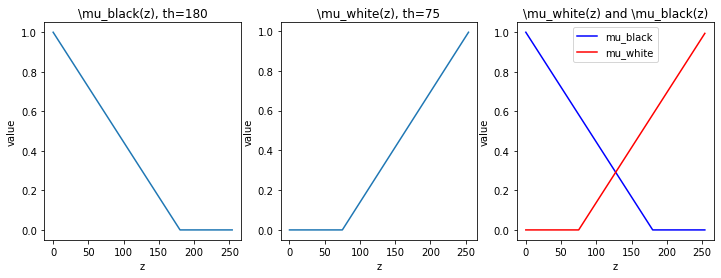

In [7]:
plt.figure(figsize=(12, 4))
xs = np.arange(0, 255)
ys1 = [muBlack(x) for x in xs]
plt.subplot(131); plt.plot(xs, ys1); plt.title('\mu_black(z), th=180'); plt.xlabel('z'); plt.ylabel('value')
ys2 = [muWhite(x) for x in xs]
plt.subplot(132); plt.plot(xs, ys2); plt.title('\mu_white(z), th=75'); plt.xlabel('z'); plt.ylabel('value')
plt.subplot(133); plt.plot(xs, ys1, c='blue', label='mu_black'); plt.plot(xs, ys2, c='red', label='mu_white')
plt.title('\mu_white(z) and \mu_black(z)'); plt.xlabel('z'); plt.ylabel('value'); plt.legend()
plt.show()

array([[113,  80,  65],
       [129,  99,  79],
       [134, 115, 102]], dtype=uint8)

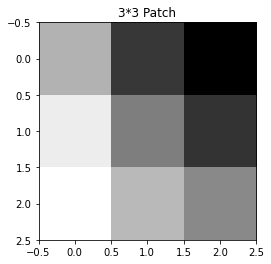

In [8]:
# 4 - 3×3邻域操作
# a)
patch = menImg[0:3, 0:3]
plt.figure(); display(patch, '3*3 Patch')
patch

In [9]:
# b)
diff = patch.flatten().astype(np.int16)
diff = diff - diff[len(diff) // 2]
diff = diff.reshape(patch.shape)
diff # d1~d9

array([[ 14, -19, -34],
       [ 30,   0, -20],
       [ 35,  16,   3]], dtype=int16)

In [10]:
# c)
diff = diff.flatten()
muZeroDs = [-1, *[muZeroD(x) for x in diff]]
muZeroDs[2], muZeroDs[6]

(0.1644744565771549, 0.1353352832366127)

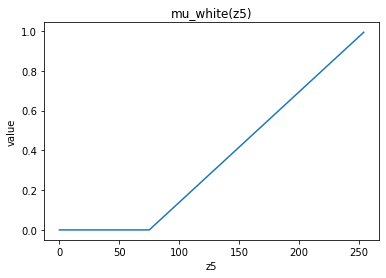

In [11]:
z5 = np.arange(0, 255)
muWhiteZ5 = [muWhite(x) for x in z5]
plt.figure(); plt.plot(z5, muWhiteZ5); plt.title('mu_white(z5)'); plt.xlabel('z5'); plt.ylabel('value')
plt.show()

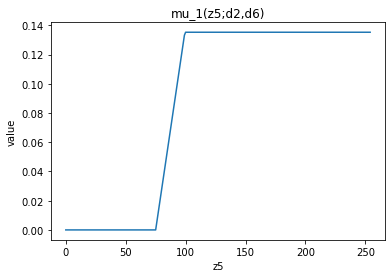

In [12]:
mu1Z5D2D6 = [min(muWhite(x), muZeroDs[2], muZeroDs[6]) for x in z5]
plt.figure(); plt.plot(z5, mu1Z5D2D6); plt.title('mu_1(z5;d2,d6)'); plt.xlabel('z5'); plt.ylabel('value')
plt.show()

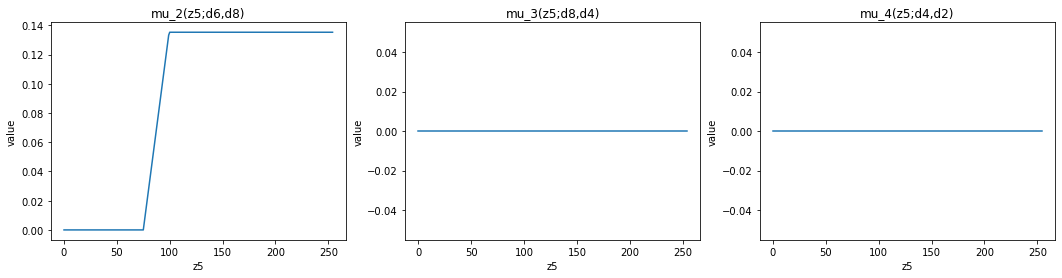

In [13]:
# d)
mu2Z5D6D8 = [min(muWhite(x), muZeroDs[6], muZeroDs[8]) for x in z5]
mu3Z5D8D4 = [min(muWhite(x), muZeroDs[8], muZeroDs[4]) for x in z5]
mu4Z5D4D2 = [min(muWhite(x), muZeroDs[4], muZeroDs[2]) for x in z5]
plt.figure(figsize=(18, 4));
plt.subplot(131); plt.plot(z5, mu2Z5D6D8); plt.title('mu_2(z5;d6,d8)'); plt.xlabel('z5'); plt.ylabel('value')
plt.subplot(132); plt.plot(z5, mu3Z5D8D4); plt.title('mu_3(z5;d8,d4)'); plt.xlabel('z5'); plt.ylabel('value')
plt.subplot(133); plt.plot(z5, mu4Z5D4D2); plt.title('mu_4(z5;d4,d2)'); plt.xlabel('z5'); plt.ylabel('value')
plt.show()

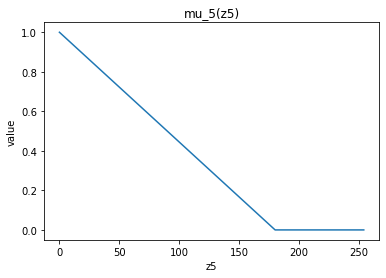

In [14]:
# e)
mu5Z5 = [muBlack(x) for x in z5]
plt.figure(); plt.plot(z5, mu5Z5); plt.title('mu_5(z5)'); plt.xlabel('z5'); plt.ylabel('value')
plt.show()

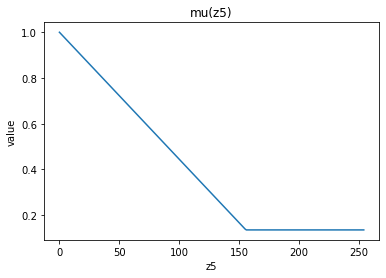

In [15]:
# f)
muZ5 = [max(mu1Z5D2D6[x], mu2Z5D6D8[x], mu3Z5D8D4[x], mu4Z5D4D2[x], mu5Z5[x]) for x in range(len(z5))]
plt.figure(); plt.plot(z5, muZ5); plt.title('mu(z5)'); plt.xlabel('z5'); plt.ylabel('value')
plt.show()

In [16]:
# g)
muZ5 = np.array(muZ5)
z5Apply = np.sum(z5 * muZ5) / np.sum(muZ5)
z5Apply = np.round(z5Apply).clip(0, 255).astype(np.uint8)
z5Apply

77

In [17]:
# 5 - 全图操作（CUDA加速）
tic = time.time()
res = fuzzyEdgeExtract3x3(menImg, SIGMA)
toc = time.time()
print('Time elapsed: %.2f s' % (toc - tic))

Time elapsed: 0.03 s


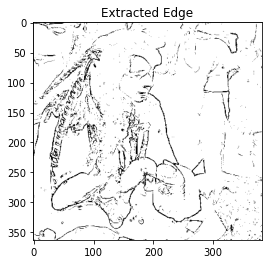

In [18]:
display(res, 'Extracted Edge')